# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math
import collections
import os

#Initialize mean slope values circle buffer with sensible values
right_mean_slope_buffer = collections.deque(maxlen=10)
right_mean_slope_buffer.append(.6)
left_mean_slope_buffer = collections.deque(maxlen=10)
left_mean_slope_buffer.append(-.7)

In [7]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #import global circular buffer for left and right line slopes
    global right_mean_slope_buffer
    global left_mean_slop_buffer
    
    #convert collection to list
    right_mean_slope = list(right_mean_slope_buffer)
    #get mean value of list
    right_mean_slope = (sum(right_mean_slope_buffer)/len(right_mean_slope_buffer))
    
    #convert collection to list
    left_mean_slope = list(left_mean_slope_buffer)
    #get mean value of list
    left_mean_slope = (sum(left_mean_slope_buffer)/len(left_mean_slope_buffer))
    
    
    if lines is not None:
        #empty lists for storing x1,y1,x2,y2,slope,y_intercept for right and left lane lines.
        right=[]
        left=[]

        #iterate through hough transform results

        for line in lines:
            for x1,y1,x2,y2 in line:
                
                

                #calculate slope rise/run
                slope = (y2-y1)/(x2-x1)
                

                #calculate y-intercept y=m*x+b
                y_intercept = (y1-slope*x1)

                #select positive slope lines for right line/filter out lines which are too vertical (slope->inf) or horizontal(slope=0)
                if slope > right_mean_slope-.1 and slope < right_mean_slope+.1:
                    #store x1->[0],y1->[1],x2->[2],y2->[3],slope->[4],y_intercept->[5] into array
                    right_coords = [x1,y1,x2,y2, slope, y_intercept]
                    #append new values array to array
                    right.append(right_coords)
                    

                #select negqative slope lines for left line/filter out lines which are too vertical (slope->inf) or horizontal(slope=0)
                if slope > left_mean_slope-.1 and slope < left_mean_slope+.1:
                    #store x1->[0],y1->[1],x2->[2],y2->[3],slope->[4],y_intercept->[5] into array
                    left_coords = [x1,y1,x2,y2, slope, y_intercept]
                    #append new values array to array
                    left.append(left_coords)
                    
        



        #convert to np.array
        right = np.asarray(right)
        left = np.asarray(left)

        #column-wise mean
        right_mean=np.mean(right, axis=0)
        left_mean=np.mean(left, axis=0)

        #column-wise stdev
        right_std=np.std(right, axis=0)
        left_std=np.std(left, axis=0)

        if (right.size>0) and (left.size>0):

            #Filter outliers within 2 standard dev avg_slope-std_dev<slope<avg_slop+std_dev
            right = right[ (right_mean[4]+2*right_std[4]>right[:,4]) & (right[:,4]>right_mean[4]-2*right_std[4]) ]
            left = left[ (left_mean[4]+2*left_std[4]>left[:,4]) & (left[:,4]>left_mean[4]-2*left_std[4]) ]
            
            #Filter outliers within 2 standard dev avg_slope-std_dev<slope<avg_slop+std_dev
            right = right[ (right_mean[5]+2*right_std[5]>right[:,5]) & (right[:,5]>right_mean[5]-2*right_std[5]) ]
            left = left[ (left_mean[5]+2*left_std[5]>left[:,5]) & (left[:,5]>left_mean[5]-2*left_std[5]) ]
            

            #re-calculate mean without outliers
            right_mean=np.mean(right, axis=0)
            left_mean=np.mean(left, axis=0)
            
            #Check that list is not empty
            if right.size >= 1:
                
                #right average line
                #first point right at bottom-edge
                #y1=bottom_edge
                y1=img.shape[0]
                #x1 defined from x=(y-b)/m
                x1=(y1-right_mean[5])/right_mean[4]
                #convert to integer to map to pixel
                x1=x1.astype(int)
                #y2 position near vanishing point
                y2=.6*img.shape[0]
                y2=int(y2)
                #x2 defined from x=(y-b)/m
                x2=(y2-right_mean[5])/right_mean[4]
                #convert to integer to map to pixel
                x2=x2.astype(int)
                
                #Draw red right line from (x1,y1)->(x2,y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

                right_mean_slope_buffer.append(right_mean[4])

            
            #Check that list is not empty
            if left.size >= 1:
                #right average line
                #first point left at bottom-edge
                #y1=bottom_edge
                y1=img.shape[0]

                #x1 defined from x=(y-b)/m
                x1=(y1-left_mean[5])/left_mean[4]
                #convert to integer to map to pixel
                x1=x1.astype(int)
                #y2 position near vanishing point
                y2=.6*img.shape[0]
                y2=int(y2)
                #x2 defined from x=(y-b)/m
                x2=(y2-left_mean[5])/left_mean[4]
                #convert to integer to map to pixel
                x2=x2.astype(int)
                
                #Draw left green line from (x1,y1)->(x2,y2)    
                cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)
                #cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)
                
                left_mean_slope_buffer.append(left_mean[4])
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    imshape = image.shape
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    blank_image = np.zeros((image.shape[0],image.shape[1],3), np.uint8)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Four sided polygon mask
    
    #1/50 of resolution left of center
    top_left_x_polygon=int(imshape[1]/2-imshape[1]/50)
    #1/50 of resolution left of center
    top_left_y_polygon=int(.6*imshape[0])
    #1/50 of resolution right of center
    top_right_x_polygon=int(imshape[1]/2+imshape[1]/50)
    #60% down from top
    top_right_y_polygon=top_left_y_polygon
    
    vertices = np.array([[(0,imshape[0]),(top_left_x_polygon, top_left_y_polygon), (top_right_x_polygon, top_right_y_polygon), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)


    # Iterate over the output "lines" and draw lines on a blank image
    draw_lines(blank_image, lines, color=[255, 0, 0], thickness=10)
    
    # Merge lines with weight onto original video frame
    image = weighted_img(image, blank_image, α=0.8, β=1., λ=0.)
    

    return image

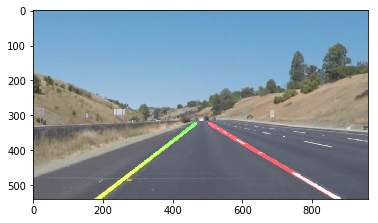

In [10]:
#Go through test images and run process_image on all of them
for subdir, dirs, files in os.walk("test_images"):
    for file in files:
        #print os.path.join(subdir, file)
        filepath_open = subdir + os.sep + file
        filepath_store = 'test_images_output' + os.sep + file

        if filepath_store.endswith(".jpg"):
            image = mpimg.imread(filepath_open)
            plt.imshow(process_image(image))
            plt.savefig(filepath_store)



In [11]:
#Go through test videos and run process_image on all of them
for subdir, dirs, files in os.walk("test_videos"):
    for file in files:
        #print os.path.join(subdir, file)
        filepath_open = subdir + os.sep + file
        filepath_store = 'test_videos_output' + os.sep + file
        print (filepath_open)

        if filepath_store.endswith(".mp4"):
            clip2 = VideoFileClip(filepath_open)
            challenge_clip = clip2.fl_image(process_image)
            %time challenge_clip.write_videofile(filepath_store, audio=False)



test_videos\challenge.mp4
[MoviePy] >>>> Building video test_videos_output\challenge.mp4
[MoviePy] Writing video test_videos_output\challenge.mp4


100%|████████████████████████████████████████| 251/251 [00:06<00:00, 36.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\challenge.mp4 

Wall time: 7.51 s
test_videos\solidWhiteRight.mp4
[MoviePy] >>>> Building video test_videos_output\solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output\solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:02<00:00, 74.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\solidWhiteRight.mp4 

Wall time: 3.34 s
test_videos\solidYellowLeft.mp4
[MoviePy] >>>> Building video test_videos_output\solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output\solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:09<00:00, 70.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\solidYellowLeft.mp4 

Wall time: 9.97 s
